In [15]:
# importing all the required Libraries
import glob
import json
import csv
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import string
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings("ignore")

In [17]:
file=glob.glob('E:\CapstoneProject\ReviewSample.json')

In [18]:
# Reading a multiple json files from a single json file 'ReviewSample.json'.
review=[]
with open(file[0]) as data_file:
    data=data_file.read()
    for i in data.split('\n'):
        review.append(i)
        
# Making a list of Tuples containg all the data of json files.
reviewDataframe=[]
for x in review:
    try:
        jdata=json.loads(x)
        reviewDataframe.append((jdata['reviewerID'],jdata['asin'],jdata['reviewerName'],jdata['helpful'][0],jdata['helpful'][1],jdata['reviewText'],jdata['overall'],jdata['summary'],jdata['unixReviewTime'],jdata['reviewTime'])) 
    except:
        pass        
    
# Creating a dataframe using the list of Tuples got in the previous step.    
dataset=pd.DataFrame(reviewDataframe,columns=['Reviewer_ID','Asin','Reviewer_Name','helpful_UpVote','Total_Votes','Review_Text','Rating','Summary','Unix_Review_Time','Review_Time'])

In [19]:
def NaiveBaiyes_Sentimental(sentence):
    blob = TextBlob(sentence, analyzer=NaiveBayesAnalyzer())
    NaiveBayes_SentimentScore=blob.sentiment.classification
    return NaiveBayes_SentimentScore

In [20]:
# VADER sentiment analysis tool for getting Compound score.
def sentimental(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    return score

# VADER sentiment analysis tool for getting pos, neg and neu.
def sentimental_Score(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    if score >= 0.5:
        return 'pos'
    elif (score > -0.5) and (score < 0.5):
        return 'neu'
    elif score <= -0.5:
        return 'neg'

In [21]:
Selected_Rows=dataset.head(100000)
Selected_Rows['Sentiment_Score']=Selected_Rows['Review_Text'].apply(lambda x: sentimental_Score(x))

In [22]:
Selected_Rows.to_csv(r'E:\CapstoneProject\sentimental.csv')

In [23]:
pos = Selected_Rows.loc[Selected_Rows['Sentiment_Score'] == 'pos']
neg = Selected_Rows.loc[Selected_Rows['Sentiment_Score'] == 'neg']

In [24]:
def stemming(tokens):
    ps=PorterStemmer()
    stem_words=[]
    for x in tokens:
        stem_words.append(ps.stem(x))
    return stem_words

In [25]:
def create_Word_Corpus(df):
    words_corpus = ''
    for val in df["Summary"]:
        text = val.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = stemming(tokens)
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus

In [26]:
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    plt.savefig('wordclouds.png', facecolor='k', bbox_inches='tight')

In [33]:
pos_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(pos))
neg_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neg))

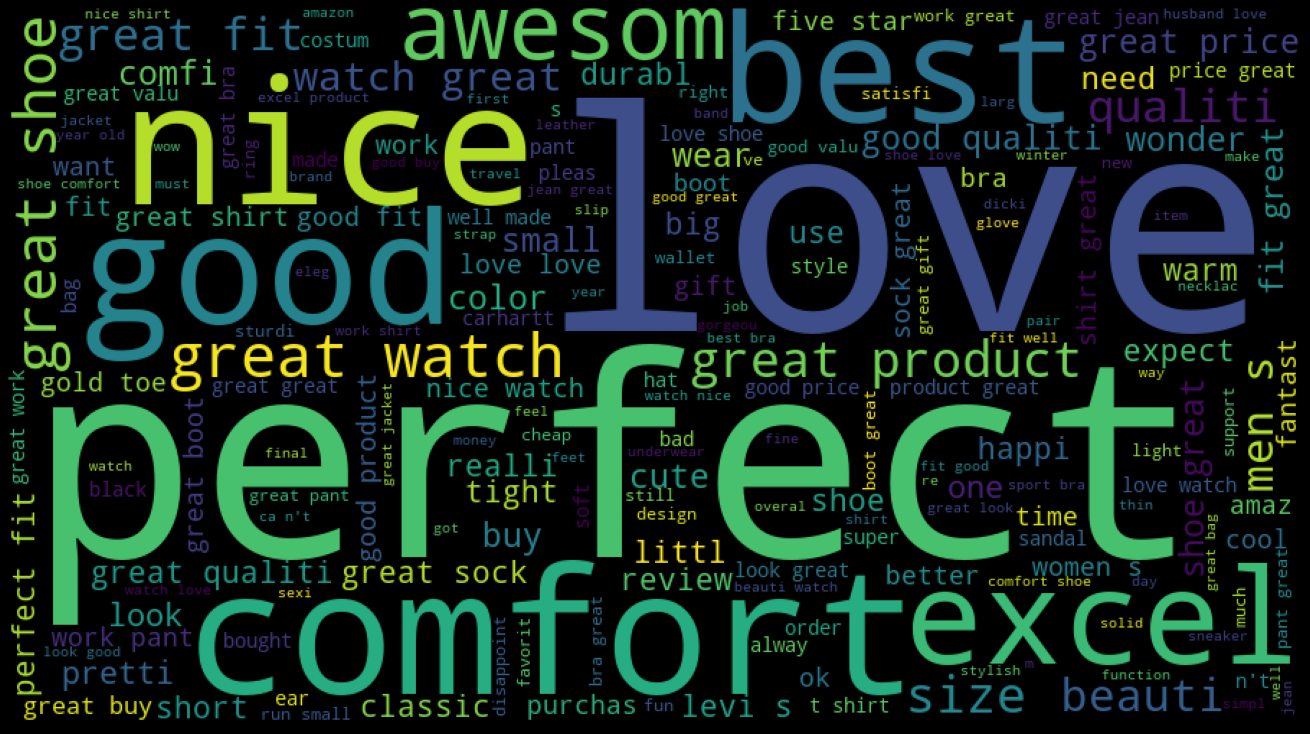

<Figure size 432x288 with 0 Axes>

In [34]:
plot_Cloud(pos_wordcloud)

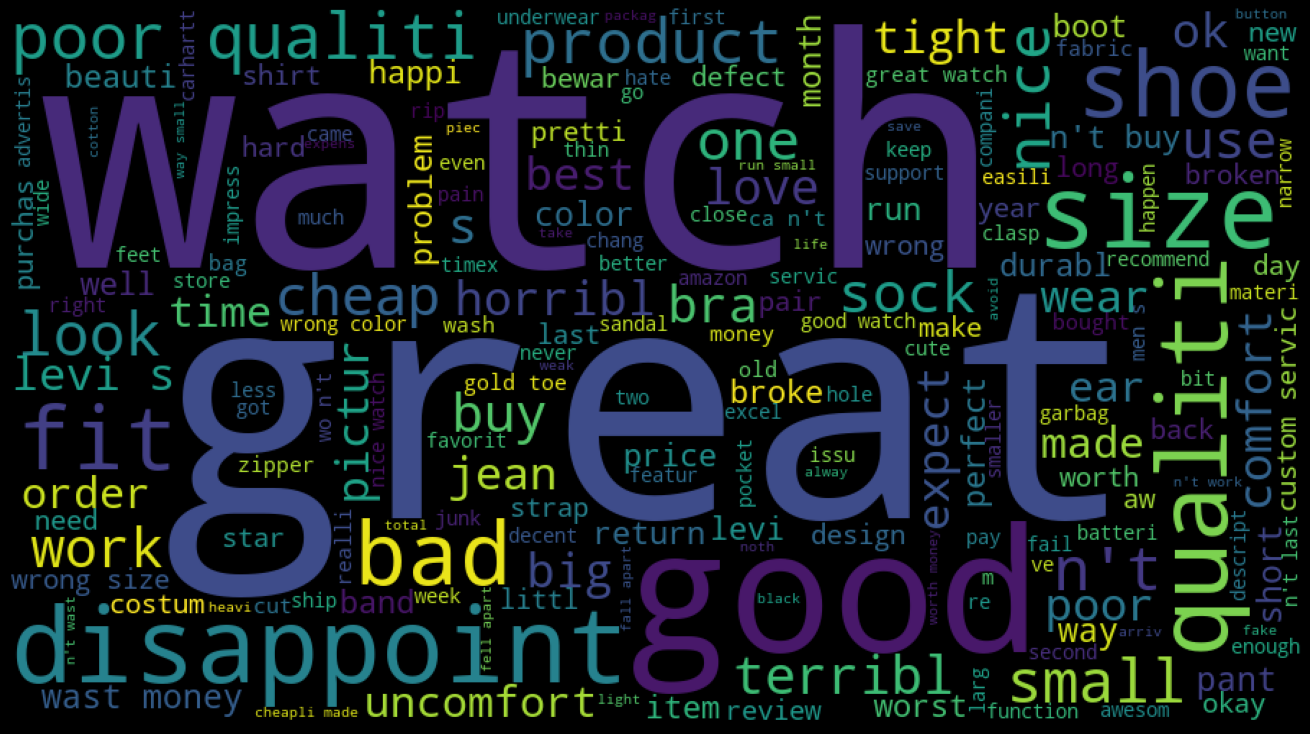

<Figure size 432x288 with 0 Axes>

In [35]:
plot_Cloud(neg_wordcloud)

# SENTIMENT DISTRIBUTION ACROSS EACH PRODUCT ALONG WITH THEIR NAMES MAPPED FROM PRODUCT DATABASE.

In [36]:
file2=glob.glob('E:\CapstoneProject\ProductSample.json')

In [37]:
# Reading a multiple json files from a single json file 'ProductSample.json'.
product=[]
with open(file2[0]) as data_file:
    data=data_file.read()
    for i in data.split('\n'):
        product.append(i)
        
# Firstly cleaning the data by converting files into proper json format files by some replacements and 
# then Making a list of Tuples containg all the data of json files.        
productDataframe=[]
for x in product:
    try:
        y=x.replace("'",'"')
        jdata=json.loads(y)
        productDataframe.append((jdata['asin'],jdata['title'])) 
    except:
        pass
    
# Creating a dataframe using the list of Tuples got in the previous step.     
Product_dataset=pd.DataFrame(productDataframe,columns=['Asin','Title'])

In [38]:
Sentimemt_Score_Product=Selected_Rows[['Asin','Sentiment_Score']]

In [39]:
Sentimemt_Score_Product=Sentimemt_Score_Product.groupby(['Asin','Sentiment_Score']).size().reset_index()

In [40]:
# Creating a new column with value of 'Sentimemt_Score_Product[0]' so that it is accessible with the index name.
Sentimemt_Score_Product['Count']=Sentimemt_Score_Product[0]

# Taking the Required columns only.
Sentimemt_Score_Product=Sentimemt_Score_Product[['Asin','Sentiment_Score','Count']]

In [42]:
x1=Sentimemt_Score_Product.sort_values(['Asin','Count'],ascending=True).groupby(['Asin']).head()

In [43]:
x2=Product_dataset

In [44]:
result=pd.merge(x2, x1, on='Asin', how='inner')

In [45]:
result.to_csv('E:\CapstoneProject\Sentiment_Distribution_Across_Product.csv')

# PERCENTAGE DISTRIBUTION OF POSITIVE, NEUTRAL AND NEGATIVE IN TERMS OF SENTIMENTS.

In [54]:
Percentage=result.groupby('Sentiment_Score')['Count'].sum().reset_index()

In [55]:
Percentage['Percentage']=(Percentage.Count/Percentage.Count.sum())*100

In [49]:
result_Positive = result_Positive.drop('index', 1)
result_Negative = result_Negative.drop('index', 1)
result_Neutral = result_Neutral.drop('index', 1)

In [56]:
Percentage.to_csv('E:\CapstoneProject\Sentiment_Percentage.csv')

# SENTIMENT DISTRIBUTION ACROSS THE YEAR

In [57]:
Selected_Rows['Review_Time']= pd.to_datetime(Selected_Rows['Review_Time'])

In [58]:
Selected_Rows['Month']=Selected_Rows['Review_Time'].dt.month

In [59]:
Selected_Rows['Year']=Selected_Rows['Review_Time'].dt.year

In [60]:
Sentiment_Year=Selected_Rows.groupby(['Year','Sentiment_Score'])['Asin'].count().reset_index()

In [61]:
Sentiment_Year=Sentiment_Year.rename(columns={'Asin': 'Count'})

In [62]:

Positive_Year = Sentiment_Year[Sentiment_Year.Sentiment_Score == 'pos']
Negative_Year = Sentiment_Year[Sentiment_Year.Sentiment_Score == 'neg']
Neutral_Year = Sentiment_Year[Sentiment_Year.Sentiment_Score == 'neu']

In [63]:
Sentiment_Total_Year=Sentiment_Year.groupby('Year')['Count'].sum().reset_index()

In [64]:
Sentiment_Total_Year=Sentiment_Total_Year.rename(columns={'Count': 'Total_Count'})

In [65]:

result_Positive_Year=pd.merge(Positive_Year, Sentiment_Total_Year, on='Year', how='inner')
result_Negative_Year=pd.merge(Negative_Year, Sentiment_Total_Year, on='Year', how='inner')
result_Neutral_Year=pd.merge(Neutral_Year, Sentiment_Total_Year, on='Year', how='inner')

In [66]:
result_Positive_Year['Percentage']=(result_Positive_Year['Count']/result_Positive_Year['Total_Count'])*100
result_Negative_Year['Percentage']=(result_Negative_Year['Count']/result_Negative_Year['Total_Count'])*100
result_Neutral_Year['Percentage']=(result_Neutral_Year['Count']/result_Neutral_Year['Total_Count'])*100

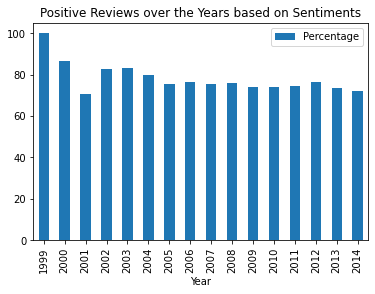

In [68]:
result_Positive_Year.plot(x="Year",y="Percentage",kind="bar",title="Positive Reviews over the Years based on Sentiments")
plt.show()

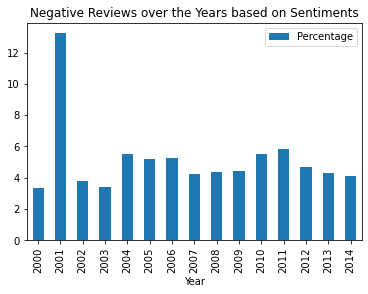

In [69]:
result_Negative_Year.plot(x="Year",y="Percentage",kind="bar",title="Negative Reviews over the Years based on Sentiments")
plt.show()

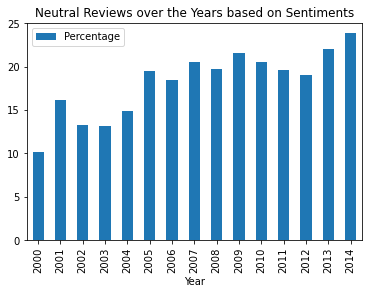

In [70]:
result_Neutral_Year.plot(x="Year",y="Percentage",kind="bar",title="Neutral Reviews over the Years based on Sentiments")
plt.show()